In [138]:
import random
import json
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

random.seed(6)
np.random.seed(6)


# Experiment 7 - Llama3.1 8b as a judge

In this experiment I implement the technique `LLM as judge` used in the paper `How good is my MML?` as evaluaiton metric for the correctness of the answers given by a model. The method 
consists of using a LLM to evaluate the correctness of the answers given by another model. The LLM acts as a judge by comparing the predicted answer with the ground truth answer and providing a score between 0 and 5, expressing the confidence in the answer. The judge also provides a reason for the score.


**Parameters:**
- model: llama3.1 8b
- system prompt: LLM_judge_system.txt
- temperature: 0.1
- sampling method: (default) top-p (p=0.9)


Let's load the ground truth from the `STAR_QA_question_and_stsg_val.json` file where we extracted QA and spatio-temporal scene graphs

In [139]:
ground_truth = []

with open('../data/datasets/STAR_QA_and_stsg_val.json') as f:
    data = json.load(f)
    ground_truth = [{
        'id': sample['question_id'],
        'question': sample['question'],
        'choices': sample['choices'],
        'num': sample['answer'],
        'text': sample['choices'][str(sample['answer'])]
    } for sample in data]


# we keep num as str so we can directrly access choices dictionaries
gt_df = pd.DataFrame(ground_truth).astype({'id': 'string', 'num': 'string', 'text': 'string'})
gt_df.set_index('id', inplace=True)
gt_df


,question,choices,num,text
id,,,,
Interaction_T1_13,Which object was tidied up by the person?,"{'0': 'The closet/cabinet.', '1': 'The blanket...",2,The clothes.
Interaction_T1_14,Which object was tidied up by the person?,"{'0': 'The blanket.', '1': 'The table.', '2': ...",2,The clothes.
Interaction_T1_31,Which object was thrown by the person?,"{'0': 'The pillow.', '1': 'The bag.', '2': 'Th...",2,The clothes.
Interaction_T1_32,Which object was put down by the person?,"{'0': 'The food.', '1': 'The shoe.', '2': 'The...",1,The shoe.
Interaction_T1_40,Which object was tidied up by the person?,"{'0': 'The broom.', '1': 'The closet/cabinet.'...",1,The closet/cabinet.
...,...,...,...,...
Feasibility_T6_1453,What is the person able to do after taking the...,"{'0': 'Wash the table.', '1': 'Take the box.',...",0,Wash the table.
Feasibility_T6_1454,What is the person able to do after walking th...,"{'0': 'Take the towel.', '1': 'Throw the bag.'...",0,Take the towel.
Feasibility_T6_1455,What is the person able to do after walking th...,"{'0': 'Throw the bag.', '1': 'Wash the table.'...",1,Wash the table.


In [140]:
a2 = ans_regex_pattern = r'A:\s*(?:\d\.)?\s*((?:\w+(?:\s|\/)?){,10}\.)'
c2 = predictions_df['response'].str.contains(ans_regex_pattern, case=False, regex=True, flags=re.DOTALL)
c2.sum()


/tmp/ipykernel_478858/417181018.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  c2 = predictions_df['response'].str.contains(ans_regex_pattern, case=False, regex=True, flags=re.DOTALL)


6900

In [141]:
print(predictions_df[contains_ans_mask & ~c2].iloc[1,0])


<Reasoning>
To answer this question, we need to analyze the sequence of events involving the person and the pillow. The relevant Scene-Graphs are:
[['person - holding - phone/camera', 'person - in_front_of - phone/camera', 'person - sitting_on - floor', 'person - beneath - floor', 'person - leaning_on - pillow', 'person - behind - pillow'], 
 ['person - holding - phone/camera', 'person - in_front_of - phone/camera', 'person - sitting_on - floor', 'person - beneath - floor', 'person - touching - pillow', 'person - leaning_on - pillow', 'person - behind - pillow']]
From these Scene-Graphs, we can see that after holding the phone/camera, the person is sitting on the floor and has the pillow in front of them. The next relevant event is when the person starts to lean on the pillow (Scene-Graph 2), which implies that they are putting the pillow down or resting it on their shoulder.

Therefore, based on this analysis, we can conclude that:
A: The person put down the pillow after holding the p

In [142]:
ans_regex_pattern = rf'A:\s*(?:\d\.)?\s*({a_word}(?:\s{a_word}){{,9}}\b\.)'


In [143]:
predictions = []
with open('../outputs/responses_llama3.2_20250210_20:17:23.jsonl') as f:
    predictions = [json.loads(line) for line in f.readlines()]

# transforming the id key from `qid` to `id` for consistency and `response` to `answer`
predictions_df = pd.DataFrame(predictions, dtype='string').rename(columns={'qid':'id'})
predictions_df.set_index('id', inplace=True)
predictions_df

a_word = rf"\b[\w/]+\b"
ans_regex_pattern = rf'A:\s*(?:\d\.)?\s*({a_word}(?:\s{a_word}){{,9}}\.)'
#ans_regex_pattern = r'<Final answer>\s*A:\s*(?:\d\.)?\s*((?:\w+(?:\s|\/)?){,10}\.)\s*(?:</Final answer>)?'

ans_df = predictions_df['response'].str.extract(ans_regex_pattern)
ans_df.rename(columns={0: 'text'}, inplace=True)

ans_df['text'] = ans_df['text'].str.strip()
contains_ans_mask = ans_df['text'].notna()
ans_df = ans_df[contains_ans_mask]
ans_df

print(f"Answer following the template: {contains_ans_mask.value_counts()[True]}\n"
      f"{contains_ans_mask.value_counts()[True]/predictions_df.size:.2%} of the total")

print(f"\nOnly {contains_ans_mask.value_counts()[False]} samples do not contain the answer in the response with the specified format")


Answer following the template: 6902
97.24% of the total

Only 196 samples do not contain the answer in the response with the specified format


In [144]:
t1 = predictions_df[contains_ans_mask]['response'].apply(lambda x: re.findall(ans_regex_pattern, x))

len_series = t1.apply(len)


In [145]:
len_series.value_counts()


1    6507
2     367
5       8
4       8
3       5
8       3
6       2
7       2
Name: response, dtype: int64

In [146]:
contains_ans_mask.sum()


6902

In [147]:
ans_df = \
    predictions_df[contains_ans_mask]['response'] \
    .apply(lambda x: re.findall(ans_regex_pattern, x)[-1]) \
    .to_frame(name='text')

ans_df


,text
id,
Interaction_T1_13,The clothes.
Interaction_T1_14,The clothes.
Interaction_T1_32,The shoe.
Interaction_T1_40,The blanket.
Interaction_T1_43,The clothes.
...,...
Feasibility_T6_1453,Wash the table.
Feasibility_T6_1454,Wipe the table.
Feasibility_T6_1455,Take the shoe.


In [148]:
exact_match_pred = (gt_df[contains_ans_mask]['text'] == ans_df['text'])
exact_match_pred = exact_match_pred[contains_ans_mask]
exact_match_pred.shape


(6902,)

## Loading the the Judge evaluation

Now we load the judge evaluation on the responses of the perdictor model. The set of responses are saved in two different files. `llama8b_as_judge_wrong.jsonl` contains the responses that were classified as incorrect by the method with the method extraction, `llama8b_as_judge_correct.jsonl` contains the responses classified as correct.  
These two files contains only the responses for which it was able to extract an answer with the regex.

In [149]:
# Load the scores for the wrong answers
predictions_incorrect = []
with open('../outputs/llama8b_as_judge_wrong.jsonl') as f:
    predictions_incorrect = [json.loads(line) for line in f.readlines()]

# Load the scores for the correct answers
predictions_correct = []
with open('../outputs/llama8b_as_judge_correct.jsonl') as f:
    predictions_correct = [json.loads(line) for line in f.readlines()]

predictions = predictions_incorrect + predictions_correct

# Extract pred, score and reason from response dictionary into separate columns
judge_pred_df = pd.DataFrame(predictions).rename(columns={'qid':'id'})
judge_pred_df['pred'] = \
    judge_pred_df['response'] \
    .apply(lambda x: eval(x)['pred']) \
    .astype('string') 

judge_pred_df['score'] = \
    judge_pred_df['response'] \
    .apply(lambda x: int(eval(x)['score'])) \
    .astype('int32')

judge_pred_df['reason'] = \
    judge_pred_df['response'] \
    .apply(lambda x: eval(x)['reason']) \
    .astype('string')

judge_pred_df.drop('response', axis=1, inplace=True)
judge_pred_df.set_index('id', inplace=True)
judge_pred_df


,pred,score,reason
id,,,
Interaction_T1_40,incorrect,2,The predicted answer is incorrect because it s...
Interaction_T1_71,incorrect,2,The predicted answer is incorrect because it i...
Interaction_T1_78,incorrect,0,The predicted answer is incorrect because it d...
Interaction_T1_95,incorrect,0,The predicted answer is incorrect because it c...
Interaction_T1_100,incorrect,2,The predicted answer is incorrect because it s...
...,...,...,...
Feasibility_T6_1428,correct,5,The predicted answer matches the ground truth ...
Feasibility_T6_1448,correct,5,The predicted answer matches the ground truth ...
Feasibility_T6_1449,correct,5,The predicted answer is correct because it dir...


In [150]:
judge_pred_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6900 entries, Interaction_T1_40 to Feasibility_T6_1468
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   pred    6900 non-null   string
 1   score   6900 non-null   int32 
 2   reason  6900 non-null   string
dtypes: int32(1), string(2)
memory usage: 188.7+ KB


In [151]:
judge_pred_df


,pred,score,reason
id,,,
Interaction_T1_40,incorrect,2,The predicted answer is incorrect because it s...
Interaction_T1_71,incorrect,2,The predicted answer is incorrect because it i...
Interaction_T1_78,incorrect,0,The predicted answer is incorrect because it d...
Interaction_T1_95,incorrect,0,The predicted answer is incorrect because it c...
Interaction_T1_100,incorrect,2,The predicted answer is incorrect because it s...
...,...,...,...
Feasibility_T6_1428,correct,5,The predicted answer matches the ground truth ...
Feasibility_T6_1448,correct,5,The predicted answer matches the ground truth ...
Feasibility_T6_1449,correct,5,The predicted answer is correct because it dir...


In [152]:
# reindex exact_match to mirror the index of judge_pred_df
#
# This operation is need for two reasons:
# 1. have an aligned index
# 2. remove from exact_match_pred those answers that are not present in judge_pred

exact_match_pred = exact_match_pred.reindex(judge_pred_df.index)
exact_match_pred


id
Interaction_T1_40      False
Interaction_T1_71      False
Interaction_T1_78      False
Interaction_T1_95      False
Interaction_T1_100     False
                       ...  
Feasibility_T6_1428     True
Feasibility_T6_1448     True
Feasibility_T6_1449     True
Feasibility_T6_1453     True
Feasibility_T6_1468     True
Name: text, Length: 6900, dtype: boolean

## Evlaution on the answers originally marked as wrong

In [153]:
pred_percentages = judge_pred_df[~exact_match_pred]['pred'].value_counts(normalize=True) * 100

print("\nPredictions:")
print("-" * 30)
print(f"{'incorrect':10}: {pred_percentages['incorrect']:6.2f}%\n"
      f"{'correct':10}: {pred_percentages['correct']:6.2f}%")
print("-" * 30)



Predictions:
------------------------------
incorrect :  96.16%
correct   :   3.84%
------------------------------


An interesting metric, on 95% of the cases the model is concording with the deterministic classification of the answer regex extraction method

Let's analyze some of the answers

---
Let's inspect more samples...

In [154]:
judged_correct_mask = (judge_pred_df[~exact_match_pred]['pred'] == 'correct')
idx = random.choice(judged_correct_mask[judged_correct_mask].index)


print(f"Index: {idx}")
print(f"Question: {gt_df.loc[idx]['question']}")
print(f"Ground truth answer: {gt_df.loc[idx]['text']}")
print(f"Extracted answer: {ans_df.loc[idx]['text']}")
print(f"\nOriginal answer:\n\n{predictions_df.loc[idx]['response']}")
print(f"\nJudge evlauation:\n"
      f" - verdict: {judge_pred_df.loc[idx]['pred']}\n"
      f" - score: {judge_pred_df.loc[idx]['score']}\n"
      f" - reason: {judge_pred_df.loc[idx]['reason']}\n")


Index: Feasibility_T5_2403
Question: Which object is the person able to wash after taking the towel?
Ground truth answer: The table.
Extracted answer: The window.

Original answer:

<Reasoning>
To determine which object the person is able to wash after taking the towel, we need to analyze the sequence of events unfolding in the scene.

From the given Spatio-Temporal Scene-Graphs, we can see that the person is initially holding a towel and standing next to a table. The first event where the person takes the towel is not explicitly mentioned but it is implied by 'person - on_the_side_of - towel' which indicates the towel is being held.

The subsequent events show the person wiping the table with the towel, indicating that they are using the towel for cleaning purposes.

After wiping the table, we can see that the person is holding a bag and standing next to it. This suggests that the person has taken the towel from the table and is now holding it in their hand.

The final event shows the

### Distribution of confidence score

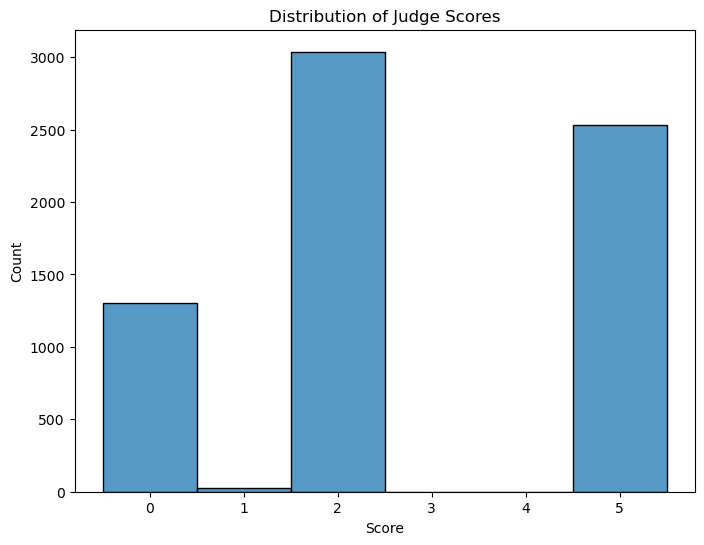

In [155]:
# Let's see the score distribution for all the predictions

plt.figure(figsize=(8, 6))
sns.histplot(data=judge_pred_df['score'], discrete=True)
plt.title('Distribution of Judge Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()


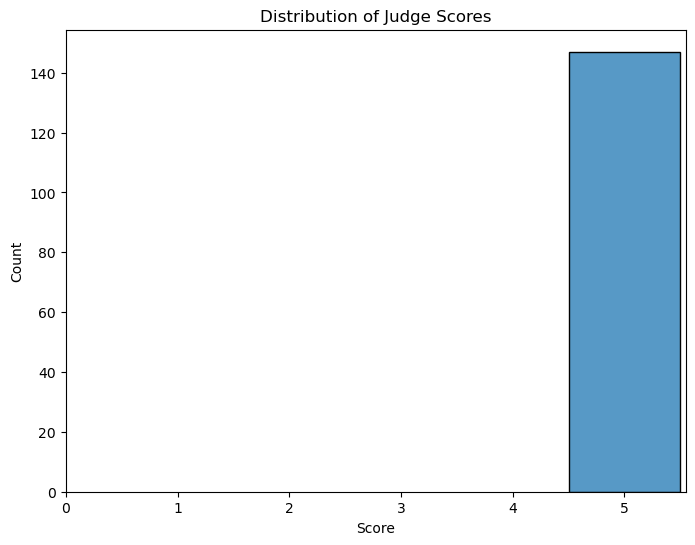

In [156]:
# Now the score distribution for the prediction which the judge considers as correct answer

plt.figure(figsize=(8, 6))
sns.histplot(data = \
             judge_pred_df \
             .loc[~exact_match_pred] \
             .loc[judged_correct_mask]['score'], discrete=True, bins=6)
plt.title('Distribution of Judge Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.xticks(range(6))
plt.show()


Not good. The LLM is very confident for these set of answers, even though we have just verified that not all them are consitent with the ground truth.

## Evaluation on the answers originally marked as correct

In [157]:
judge_pred_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6900 entries, Interaction_T1_40 to Feasibility_T6_1468
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   pred    6900 non-null   string
 1   score   6900 non-null   int32 
 2   reason  6900 non-null   string
dtypes: int32(1), string(2)
memory usage: 446.7+ KB


In [158]:
pred_percentages = judge_pred_df[exact_match_pred]['pred'].value_counts(normalize=True) * 100

print("\nPredictions:")
print("-" * 30)
print(f"{'incorrect':10}: {pred_percentages['incorrect']:6.2f}%\n"
      f"{'correct':10}: {pred_percentages['correct']:6.2f}%")
print("-" * 30)



Predictions:
------------------------------
incorrect :  22.41%
correct   :  77.59%
------------------------------


An interesting metric, on 95% of the cases the model is concording with the deterministic classification of the answer regex extraction method

Load the orignal model predictions to verify the judgement of the model.

In [159]:
judged_incorrect_mask = judge_pred_df[exact_match_pred]['pred'] == 'incorrect'

judge_pred_df[exact_match_pred][judged_incorrect_mask]


,pred,score,reason
id,,,
Interaction_T1_379,incorrect,2,The predicted answer is incorrect because it d...
Interaction_T1_1561,incorrect,2,The predicted answer is incorrect because it p...
Interaction_T1_2694,incorrect,2,The predicted answer is incorrect because it d...
Interaction_T1_3978,incorrect,2,The predicted answer is incorrect because it d...
Interaction_T1_4978,incorrect,2,The predicted answer is incorrect because it i...
...,...,...,...
Feasibility_T6_1090,incorrect,0,The predicted answer is incorrect because it d...
Feasibility_T6_1275,incorrect,2,The predicted answer is incorrect because it d...
Feasibility_T6_1298,incorrect,2,The predicted answer is incorrect because it a...


Let's analyze some of the answers

### Distribution of confidence score

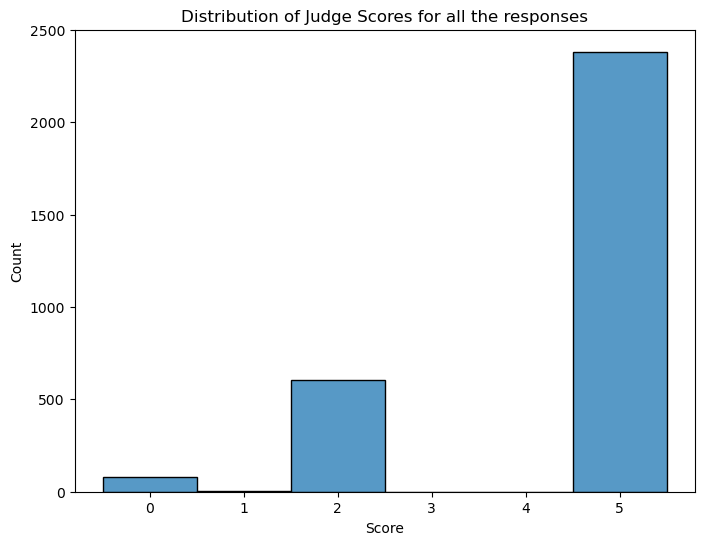

In [161]:
# Let's see the score distribution for all the predictions

plt.figure(figsize=(8, 6))
sns.histplot(data=judge_pred_df[exact_match_pred]['score'], discrete=True)
plt.title('Distribution of Judge Scores for all the responses')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()


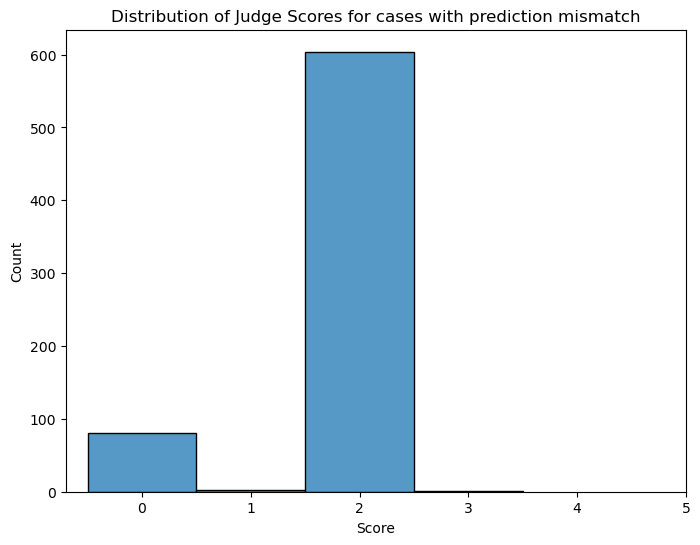

In [162]:
# Now the score distribution for the prediction which the judge considers as incorrect answers

plt.figure(figsize=(8, 6))
sns.histplot(data= \
             judge_pred_df \
             .loc[exact_match_pred]
             .loc[judged_incorrect_mask]['score'], discrete=True, bins=6)
plt.title('Distribution of Judge Scores for cases with prediction mismatch')
plt.xlabel('Score')
plt.ylabel('Count')
plt.xticks(range(6))
plt.show()


Let's check the mismatch cases where the Judge LLM is most confident (score > 2)

In [174]:
high_conf = judged_incorrect_mask[judge_pred_df['score'] > 2]
hig_conf_idxs = high_conf[high_conf].index
hig_conf_idxs


Index(['Sequence_T1_1194'], dtype='object', name='id')

In [176]:
idx = 'Sequence_T1_1194'


print(f"Index: {idx}")
print(f"Question: {gt_df.loc[idx]['question']}")
print(f"Ground truth answer: {gt_df.loc[idx]['text']}")
print(f"Extracted answer: {ans_df.loc[idx]['text']}")
print(f"\nOriginal answer:\n\n{predictions_df.loc[idx]['response']}")
print(f"\nJudge evlauation:\n"
      f" - verdict: {judge_pred_df.loc[idx]['pred']}\n"
      f" - score: {judge_pred_df.loc[idx]['score']}\n"
      f" - reason: {judge_pred_df.loc[idx]['reason']}\n")


Index: Sequence_T1_1194
Question: Which object did the person take after they put down the cup/glass/bottle?
Ground truth answer: The sandwich.
Extracted answer: The sandwich.

Original answer:

<Reasoning>
The person is first seen holding a cup/glass/bottle, and then they put it down. After that, the person is not shown to be holding anything else in their hand. The alternatives given are the phone/camera, towel, paper/notebook, and sandwich. Since the person is no longer holding a cup/glass/bottle, we can rule out options 0 (phone/camera) and 1 (towel). Option 2 (paper/notebook) seems unlikely as there's no indication that the person picked up a notebook after putting down the cup/glass/bottle. This leaves us with option 3 (sandwich), which is plausible since the person could have put down the cup/glass/bottle and then picked up a sandwich.

However, we need to consider if the person actually took the sandwich or just had it in front of them. The scene graph does not explicitly show 

Let's check the other answers

In [190]:
idx = random.choice(judged_incorrect_mask[judged_incorrect_mask].index)

print(f"Index: {idx}")
print(f"Question: {gt_df.loc[idx]['question']}")
print(f"Ground truth answer: {gt_df.loc[idx]['text']}")
print(f"Extracted answer: {ans_df.loc[idx]['text']}")
print(f"\nOriginal answer:\n\n{predictions_df.loc[idx]['response']}")
print(f"\nJudge evlauation:\n"
      f" - verdict: {judge_pred_df.loc[idx]['pred']}\n"
      f" - score: {judge_pred_df.loc[idx]['score']}\n"
      f" - reason: {judge_pred_df.loc[idx]['reason']}\n")


Index: Interaction_T3_2708
Question: What did the person do while they were holding the book?
Ground truth answer: Closed the book.
Extracted answer: Closed the book.

Original answer:

<Reasoning>
To determine what the person did while they were holding the book, we need to analyze the Scene-Graphs. The first thing that stands out is that there are multiple instances of the person holding the book, which suggests that this action is repeated at some point in time.

Looking at the relationships between the person and the book, we see that the person is both "holding" and "touching" the book. This implies that the person has physical contact with the book while holding it.

However, when examining the relationships between the person and other objects (such as the shelf), we notice that the person is often in front of or on the side of these objects. This suggests that the person may be moving towards or away from these objects while holding the book.

Considering all these points, it s

## Evaluation on the entire dataset

Let's do some visualization also for the ground truth data

In [163]:
judge_pred_correct_mask = (judge_pred_df['pred'] == 'correct')


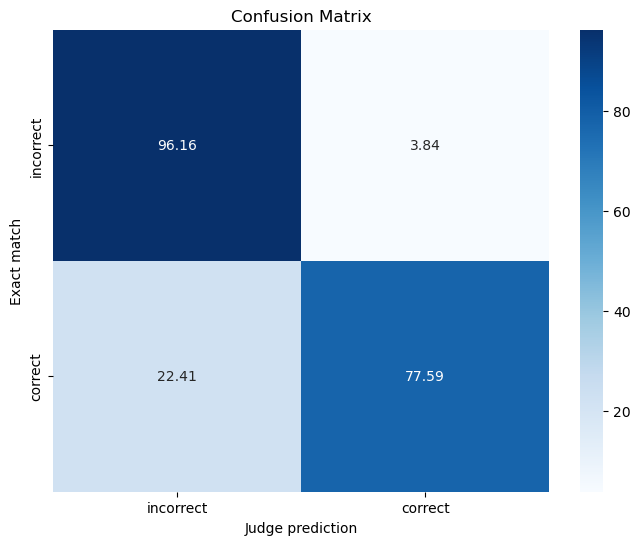

In [164]:
# Compute the confusion matrix

exact_match_labels = exact_match_pred.astype(int)
judge_pred_labels = judge_pred_correct_mask.astype(int)

cm = confusion_matrix(exact_match_labels, judge_pred_labels)

# Normalize the confusion matrix to percentage
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['incorrect', 'correct'], 
            yticklabels=['incorrect', 'correct'])
plt.xlabel('Judge prediction')
plt.ylabel('Exact match')
plt.title('Confusion Matrix')
plt.show()


In [165]:
def print_acc(eval_df, acc_fn):
    print(f"{'Question type':<15}{'Total':^15}{'Accuracy':^10}\n")

    total = eval_df.index.str.startswith('Interaction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Interaction')])
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Sequence').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Sequence')])
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Prediction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Prediction')])
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Feasibility').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Feasibility')])
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")


In [166]:
print('LLM as a Judge accuracy\n')
print_acc(judge_pred_correct_mask, lambda x: x.sum()/x.shape[0])


LLM as a Judge accuracy

Question type       Total      Accuracy 

Interaction         2308        34.45%  
Sequence            3485        37.45%  
Prediction           621        39.94%  
Feasibility          486        37.24%  


In [167]:
print('Answer extraction through regex accuracy\n')
print_acc(exact_match_pred, lambda x: x.sum()/x.shape[0])


Answer extraction through regex accuracy

Question type       Total      Accuracy 

Interaction         2308        44.58%  
Sequence            3485        44.68%  
Prediction           621        43.16%  
Feasibility          486        44.44%  
